In [9]:
import sys
import os
import os.path
import argparse
import yaml
import pickle
import pandas
import numpy
import torch
from torch.autograd import Variable
from intensix.monitor import models
from intensix.monitor import __version__
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [10]:
MODEL = "../models/HR,SpO2,InvBPSys,InvBPDias,RRtotal-15-rnn-128-3-0.5.model"
DATA = "../data/HR,SpO2,InvBPSys,InvBPDias,RRtotal"
STAYID = "Ichilov_MICU_25017"
STAY = "../data/monitor-dataset-{}.pkl".format(STAYID)

ALERT_MODEL = "../models/alerts.model"
HIDDEN_SIZE = 128

WINDOW = 15
HORIZON = 1
CONTRAST = 1.

CLOSEUP_THRESHOLD = 0.5
ALERT_THRESHOLD = 0.5

INCREMENTAL_DISPLAY = False

In [11]:
def as_batch(episode):
    """Reshapes episode as a batch.
    """
    episode = episode.reshape((episode.shape[0], 1, episode.shape[1]))
    batch = torch.from_numpy(episode).float()
    return batch


def track_episode(model, episode, depth, x0, h):
    """Runs the model through the episode, twice the window long.
    Returns 
      * next episode predictions, 
      * hidden state at the beginning of the next episode.
    """
    # Extract the input
    x = model.makex(episode, depth=0)  # use all of the episode to predict
    x = Variable(x, volatile=True)

    # Run the model forward through the input
    return model(x, depth, x0, h, missing=True)[:2]


def sigmoid(x):
    """numpy sigmoid for bounding KLs
    """
    return -1 + 2/(1 + numpy.exp(- x / CONTRAST))

In [12]:
params = torch.load(MODEL)
model = models.make(params["arch"],
                    params["input_size"],
                    **params["kwargs"])
model.load_state_dict(params["state_dict"])
model

P_RNN (
  (grus): ModuleList (
    (0): GRUCell(10, 128)
    (1): GRUCell(128, 128)
    (2): GRUCell(128, 128)
  )
  (dropout): Dropout (p = 0.5)
  (readout): Sequential (
    (0): Linear (128 -> 128)
    (1): ReLU ()
    (2): Linear (128 -> 128)
    (3): ReLU ()
    (4): Linear (128 -> 10)
  )
)

Load the data scale and column list

In [13]:
scale = numpy.load(os.path.join(DATA, "scale"))
with open(os.path.join(DATA, "columns"), "r") as f:
    columns = list(name.strip() for name in f)
assert params["input_size"] == len(columns), \
    "ERROR: incompatible model: has {} columns, " \
    "but data has {}" \
    .format(params["input_size"], len(columns))

Load the stay data frame

In [14]:
with open(STAY, "rb") as f:
    stay = pickle.load(f)

Load the filter model:

In [15]:
alert_model = models.Alert(HIDDEN_SIZE, p=0.5)
alert_model.load_state_dict(torch.load(ALERT_MODEL))
alert_model.eval()

Alert (
  (mlp): Sequential (
    (0): Linear (256 -> 256)
    (1): Dropout (p = 0.5)
    (2): ReLU ()
    (3): Linear (256 -> 128)
    (4): Dropout (p = 0.5)
    (5): ReLU ()
    (6): Linear (128 -> 1)
    (7): Sigmoid ()
  )
)

Plot KLs

time: 2010-06-05 00:56:00 severity: 0.8808 +
time: 2010-06-05 01:41:00 severity: 0.5359 +
time: 2010-06-05 13:56:00 severity: 0.5670 -
time: 2010-06-05 18:11:00 severity: 0.9685 +
time: 2010-06-05 19:11:00 severity: 0.6874 +
time: 2010-06-05 19:26:00 severity: 0.9699 +
time: 2010-06-05 20:26:00 severity: 0.7715 +
time: 2010-06-05 20:41:00 severity: 0.6614 -
time: 2010-06-05 22:26:00 severity: 0.6607 -
time: 2010-06-06 04:56:00 severity: 0.7161 +
time: 2010-06-06 05:11:00 severity: 0.5173 -
time: 2010-06-06 14:11:00 severity: 0.7353 +
time: 2010-06-06 14:26:00 severity: 0.5886 +
time: 2010-06-06 18:56:00 severity: 0.6335 -
time: 2010-06-06 19:11:00 severity: 0.5491 -
time: 2010-06-07 05:56:00 severity: 0.8811 +
time: 2010-06-07 06:56:00 severity: 0.7994 +
time: 2010-06-07 10:11:00 severity: 0.8836 +
time: 2010-06-07 10:26:00 severity: 0.8692 -
time: 2010-06-07 11:41:00 severity: 0.6675 +
time: 2010-06-07 14:56:00 severity: 0.9779 +
time: 2010-06-07 20:56:00 severity: 0.9991 +
time: 2010

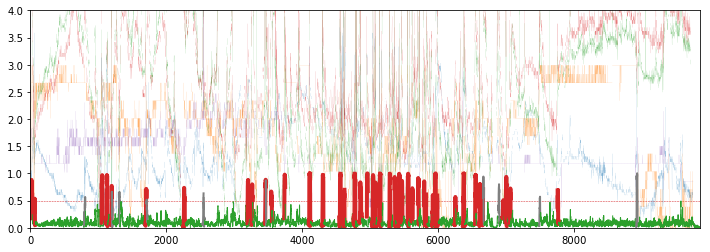

In [16]:
# Extract the time series, including missing data
observations = stay[columns].as_matrix()

# Normalize the time series
observations = (observations - scale[0])/scale[1]

# Prime the tracking
t = 0
x0 = None
hprev = None
prevs = None
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(12)
fig.set_figheight(4)
ax.set_xlim((0, len(observations)))
ax.set_ylim((0, 4))
ax.axhline(0, ls='dashed', lw=0.5, c='black')
ax.axhline(0.5, ls='dashed', lw=0.5, c='tab:red')
ax.plot(observations + 2, lw=0.1)
closeup_times = []
alert_times = []
while True:
    # Get the next episode
    episode = as_batch(observations[t:t + WINDOW])
    t += len(episode)
    # Compute prediction for the next episode
    preds, h = track_episode(model, episode, WINDOW, x0, hprev)

    x0 = preds[-1, :, 0]  # first of last step, to chain episodes
    if t == len(observations):
        break
    if prevs is not None:
        kls = models.compute_kls(
                  torch.cat([prevs[-HORIZON:, :, HORIZON - 1],
                             preds[:-HORIZON, :, HORIZON - 1]], dim=0),
                  prevs[:, :, -1])
        severities = sigmoid(kls.data[:, 0].mean(dim=1).numpy())
        color = 'tab:green'
        lw = 1
        max_severity = severities.max()
        if max_severity >= CLOSEUP_THRESHOLD:
            print("time: {} severity: {:.4f}"
                  .format(stay.index[0] + pandas.Timedelta("{} minutes".format(t)),
                          max_severity),
                  end=" ")
            closeup_times.append(t)
            closeup = torch.cat([hprev[-1, 0], h[-1, 0]], dim=0)
            closeup.resize(closeup.numel(), 1)
            if alert_model(closeup).data[0] >= ALERT_THRESHOLD:
                alert_times.append(t)
                color = 'tab:red'
                lw = 4
                print("+")
            else:
                color = 'tab:gray'
                lw = 2
                print("-")
        ax.plot(range(t - WINDOW, t), severities, c=color, lw=lw)
        
        if INCREMENTAL_DISPLAY:
            display.display(fig)
            display.clear_output(wait=True)
        else:
            print("{:06d}/{:06d}".format(t, len(observations)), end="\r")
    prevs = preds
    hprev = h

## Existing tags

In [ ]:
STAYS = "../data/stay_tags.pkl"
with open(STAYS, "rb") as f:
    stays = pickle.load(f)

if STAYID in stays:
    deterioration_tags = [tag for tag in stays[STAYID] if 'deterioration' in tag['concept']]
    print("{} has {} deterioration tags".format(STAYID, len(deterioration_tags)))
else:
    print("no deterioration tags in {}".format(STAYID))

In [ ]:
tag_times = sorted(set([tag['time'] for tag in deterioration_tags]))

tags = pandas.DataFrame({'time': tag_times,
                         'tag': [1] * len(tag_times)})
tags['time'] = pandas.to_datetime(tags['time'])
tags = tags.set_index('time')
tags = tags.reindex(stay.index, fill_value=0)

tags['closeup'] = 0
tags['closeup'][closeup_times] = 1
tags['alert'] = 0
tags['alert'][alert_times] = 1

fig, ax = plt.subplots(1, 1)
fig.set_figwidth(12)

ax.plot(tags['tag'].cumsum()/tags['tag'].sum(), label='tags')
ax.plot(tags['closeup'].cumsum()/tags['closeup'].sum(), label='closeups')
ax.plot(tags['alert'].cumsum()/tags['alert'].sum(), label='alerts')
ax.legend()